#  A simple deep CNN
[reference](https://keras.io/examples/cifar10_cnn/)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, ZeroPadding1D, Convolution1D
import os

In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import metrics
sns.set_style('whitegrid')
sns.set_palette('Set2')
# %matplotlib inline

In [3]:
def probability_to_label(probabilities, threshold=0.5):
    probabilities = list(probabilities)
    th = threshold
    predictions = [1 if i > th else 0 for i in probabilities]
    return predictions

In [4]:
def plot_cm(y_true, y_pred,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    sns.set_style('white')
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normarlize 
    
    from sklearn.utils.multiclass import unique_labels
    classes = unique_labels(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    pass

In [5]:
def plot_ROC(fpr, tpr, auc, title = 'ROC curve'):
    sns.set_style('whitegrid')

#     plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=' (AUC = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    pass

In [6]:
def plot_PRC(precision, recall, ap, title= 'Precision-Recall Curve '):
    sns.set_style('whitegrid')

    plt.figure
#     plot(result5_1[0], result5_1[1],linestyle = "-", color = 'C0')#,label = 'AUC = %0.2f' % result5_1[3])
    plt.plot(recall, precision, lw=2, label='AP = %0.4f' % ap )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")
#     plt.show()
    return 

In [7]:
train_model = True
batch_size = 32
num_classes = 2
epochs = 30
data_augmentation = False
# num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_trained_model_30_day.h5'

In [8]:
# data =pd.read_csv('data_pre_processed.csv')
testing_data = pd.read_csv('data_pp_test_30d.csv')
training_data=  pd.read_csv('data_pp_train_30d.csv')
data = training_data

In [9]:
print('Total data shape is ', data.shape)
data.head()

Total data shape is  (38857, 111)


,first_careunit,last_careunit,age,gender,marital_status,insurance,urea_n_min,urea_n_max,urea_n_mean,platelets_min,...,spo2_max_mv,spo2_mean_mv,vent_mv,rrt_mv,urineoutput_mv,oasis_mv,lods_mv,sirs_mv,thirty_days,one_year
0,0.358226,-0.375558,-0.091698,-1.125040,0.002484,0.721077,0.336293,0.533833,0.568295,-0.307287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.058760,1.040694,-0.138448,-1.125040,-0.795334,0.721077,1.458096,0.982380,1.364434,-0.617702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.358226,-0.375558,4.139580,-1.125040,-0.795334,0.721077,-0.411576,-0.523458,-0.401365,-1.206421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.058760,1.040694,0.115679,-1.125040,-0.795334,0.721077,0.261506,-0.395301,-0.145096,2.058292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.358226,-0.375558,-0.268887,0.888858,0.800302,-0.508846,0.111932,-0.299184,-0.088050,-1.067269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
columns = list(data.columns)

X = training_data[columns[0:-2]].astype(np.float32) # fetures
y = training_data[columns[-2]].astype(np.float32)  # 30 days

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_test = testing_data[columns[0:-2]].astype(np.float32) # fetures
y_test = testing_data[columns[-2]].astype(np.float32)  # 30 days

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (31085, 109)
31085 train samples
7772 validation samples
19139 test samples


In [11]:
# # Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
model = Sequential()
model.add(Conv1D(32, 3, padding='same', input_shape=[X_train.shape[1],1]))
model.add(Activation('relu'))
model.add(Conv1D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# initiate RMSprop optimizer
# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])#, km.binary_precision(), km.binary_recall()])

X_train = X_train.values[..., None].astype('float32')
X_val = X_val.values[..., None].astype('float32')
X_test = X_test.values[..., None].astype('float32')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 109, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 109, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 107, 32)           3104      
_________________________________________________________________
activation_1 (Activation)    (None, 107, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 53, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 53, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 53, 64)            6208      
__________

In [14]:
X_train.shape

(31085, 109, 1)

In [15]:
if train_model:
    hist = model.fit(X_train, y_train,
              batch_size=64,
              epochs=30,
              verbose = 1,
              validation_data=(X_val, y_val),
              shuffle=True,
                callbacks= [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)] )
    
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

else:
    # load weights 
    filepath = './saved_models/keras_trained_model_30_day.h5'
    model.load_weights(filepath, by_name=False)


Train on 31085 samples, validate on 7772 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
31085/31085 [==============================] - 7s 233us/sample - loss: 0.2748 - acc: 0.8918 - val_loss: 0.1809 - val_acc: 0.9306
Epoch 2/30
31085/31085 [==============================] - 5s 152us/sample - loss: 0.1927 - acc: 0.9296 - val_loss: 0.1409 - val_acc: 0.9502
Epoch 3/30
31085/31085 [==============================] - 5s 154us/sample - loss: 0.1626 - acc: 0.9444 - val_loss: 0.1179 - val_acc: 0.9595
Epoch 4/30
31085/31085 [==============================] - 5s 151us/sample - loss: 0.1465 - acc: 0.9517 - val_loss: 0.1096 - val_acc: 0.9646
Epoch 5/30
31085/31085 [==============================] - 5s 154us/sample - loss: 0.1340 - acc: 0.9549 - val_loss: 0.0995 - val_acc: 0.9665
Epoch 6/30
31085/31085 [==============================] - 5s 158us/sample - loss: 0.1261 - acc: 0.9575 - val_loss: 0.0924 - val_acc: 0.9677
Epoch 7/30
31085/31085 [==============================] - 5s 15

In [16]:

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

19139/19139 [==============================] - 2s 83us/sample - loss: 0.0824 - acc: 0.9738
Test loss: 0.08244851256577025
Test accuracy: 0.9738231


In [17]:
y_score = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc = metrics.auc(fpr, tpr)
auc

0.9852682561126527

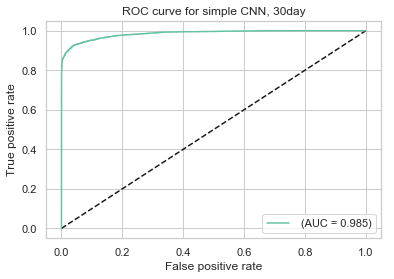

In [18]:
plot_ROC(fpr, tpr, auc, title = 'ROC curve for simple CNN, 30day')

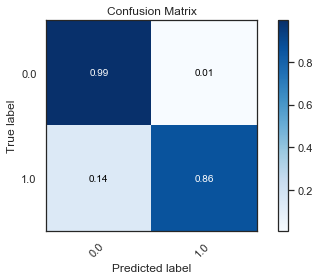

In [19]:
y_pred = probability_to_label(y_score, threshold=0.5)
plot_cm(y_test, y_pred)

In [20]:
average_precision = metrics.average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.96


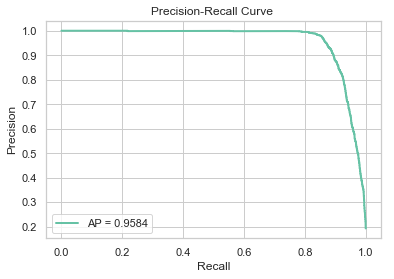

In [21]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
plot_PRC(precision, recall, average_precision)

# Modified VGG16
[reference](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)

In [22]:
model = Sequential()
model.add(ZeroPadding1D(1,input_shape=[X_train.shape[1],1]))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(ZeroPadding1D(1))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2, strides=2))

model.add(ZeroPadding1D(1))
model.add(Convolution1D(128, 3, activation='relu'))
model.add(ZeroPadding1D(1))
model.add(Convolution1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2, strides=2))

model.add(ZeroPadding1D(1))
model.add(Convolution1D(256, 3, activation='relu'))
model.add(ZeroPadding1D(1))
model.add(Convolution1D(256, 3, activation='relu'))
model.add(ZeroPadding1D(1))
model.add(Convolution1D(256, 3, activation='relu'))
model.add(MaxPooling1D(2, strides=2))

model.add(ZeroPadding1D(1))
model.add(Convolution1D(512, 3, activation='relu'))
model.add(ZeroPadding1D(1))
model.add(Convolution1D(512, 3, activation='relu'))
model.add(ZeroPadding1D(1))
model.add(Convolution1D(512, 3, activation='relu'))
model.add(MaxPooling1D(2, strides=2))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))



In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'] )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d (ZeroPadding1 (None, 111, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 109, 64)           256       
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 111, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 109, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 54, 64)            0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 56, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 54, 128)           24704     
__________

In [24]:
if train_model:
    hist = model.fit(X_train, y_train,
              batch_size=64,
              epochs=30,
              verbose = 1,
              validation_data=(X_val, y_val),
              shuffle=True,
                callbacks= [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)] )
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, 'Modified_VGG_30_day.h5')
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)
else:
    # load weights 
    filepath = './saved_models/Modified_VGG_30_day.h5'
    model.load_weights(filepath, by_name=False)


Train on 31085 samples, validate on 7772 samples
Epoch 1/30
31085/31085 [==============================] - 31s 986us/sample - loss: 0.3475 - acc: 0.8685 - val_loss: 0.1767 - val_acc: 0.9400
Epoch 2/30
31085/31085 [==============================] - 30s 955us/sample - loss: 0.1742 - acc: 0.9442 - val_loss: 0.1303 - val_acc: 0.9577
Epoch 3/30
31085/31085 [==============================] - 28s 898us/sample - loss: 0.1346 - acc: 0.9601 - val_loss: 0.1417 - val_acc: 0.9595
Epoch 4/30
31085/31085 [==============================] - 28s 901us/sample - loss: 0.1213 - acc: 0.9636 - val_loss: 0.1063 - val_acc: 0.9690
Epoch 5/30
31085/31085 [==============================] - 28s 898us/sample - loss: 0.1109 - acc: 0.9673 - val_loss: 0.0931 - val_acc: 0.9700
Epoch 6/30
31085/31085 [==============================] - 24s 787us/sample - loss: 0.1069 - acc: 0.9679 - val_loss: 0.0926 - val_acc: 0.9734
Epoch 7/30
31085/31085 [==============================] - 24s 758us/sample - loss: 0.1020 - acc: 0.9701 -

In [25]:


# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

19139/19139 [==============================] - 5s 243us/sample - loss: 0.0911 - acc: 0.9727
Test loss: 0.09111433670101765
Test accuracy: 0.97272587


In [26]:
y_score = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc = metrics.auc(fpr, tpr)
auc

0.9794292800178209

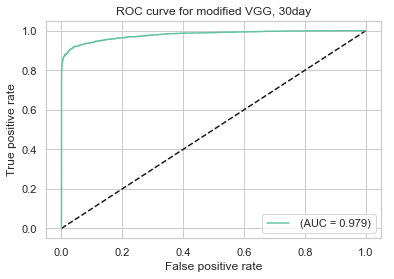

In [31]:
plot_ROC(fpr, tpr, auc, title = 'ROC curve for modified VGG, 30day')

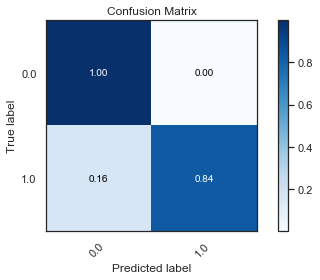

In [28]:
y_pred = probability_to_label(y_score, threshold=0.5)
plot_cm(y_test, y_pred)

In [29]:
average_precision = metrics.average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.95


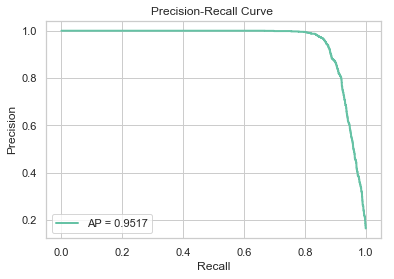

In [30]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
plot_PRC(precision, recall, average_precision)